## Comparing Ray,  Parsl & Dask on a simple multicore system
This notebook compares Parsl and Dask on a trivial bag-of-task problem running on a ubuntu aws c5a.4xlarge.   the VM has 8 real cores (capable of 16 fully concurrent threads.)

The basic test is to compute pi 100 times using 1, 2, 4, 5, 10 and 100 concurrent tasks.  


In [1]:
#!pip install parsl

In [2]:
#pip install "dask[bag]" --upgrade

In [3]:
import dask
import dask.bag as db

In [4]:
def do_pi(numpoints):
    from random import random
    inside = 0
    for i in range(numpoints):
        x, y = random(), random()  # Drop a random point in the box.
        if x**2 + y**2 < 1:        # Count points within the circle.
            inside += 1
    pi = inside*4 / numpoints
    return pi


compute pi with 10\*\*8 interation which is about the same work as 100 iterations of 10**6.

In [5]:
import time
t0 = time.time()
x = do_pi((10**6)*100)
print("pi =", x)
t1 =time.time()
print(t1-t0)

pi = 3.14168156
29.72766661643982


the function do_dask uses dask bags to express the concurrency.   we start with a list of 100 copies of the  value 10\*\*6.  next create a bag from this list and partition this bag into "nparts" partitions.  We use a lambda expression to map the elements of the bag to the do_pi function and then compute the mean of the values. 

In [6]:
import time

In [7]:
def do_dask(nparts):
    seq = [10**6 for i in range(100)]
    bagseq = db.from_sequence(seq, npartitions = nparts)
    t0 = time.time()
    c = bagseq.map(lambda x: do_pi(x)).mean()
    x =c.compute()
    t1 =time.time()
    print("time =", t1-t0)
    return t1-t0

We now run do task for different partition sizes.   if the partition size is x then there will be x threads assigned to the computation.

In [8]:
blocklist = [1, 2, 4, 5, 10, 20, 100]
dask_vals = []
for i in blocklist:
    dask_vals.append(do_dask(i))

time = 28.0891375541687
time = 14.39387845993042
time = 7.553773880004883
time = 6.106798887252808
time = 4.172786474227905
time = 3.8472983837127686
time = 3.1572248935699463


In [29]:
#!pip install "dask[distributed]" --upgrade

Dask also has a distributed package.   this will set up a cluster as snown below.

In [9]:
from dask.distributed import Client, progress, fire_and_forget

In [10]:
cl = Client()
cl

Client Scheduler: tcp://127.0.0.1:35327 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 33.30 GB


now if we partition our bag into 4 sets which is the same size as our cluster we can do the computation as follows.  the result is about the same as we saw above.

In [11]:
seq = [10**6 for i in range(100)]
bagseq = db.from_sequence(seq, npartitions = 4)
t0 = time.time()
x = cl.compute(bagseq.map(lambda x: do_pi(x)).mean())
while x.status != 'finished':
    time.sleep(.3)
#x =cl.compute(bs)
t1 = time.time()
print(x.result())
print(t1-t0)

3.1415610400000005
8.111969470977783


## Parsl
For parsl we will use a local high throughput executor as configured below.   NOTE: this does not work on Windows10, but it is fine on our Azure ubuntu data science VM

In [12]:
from parsl import python_app
import parsl

In [13]:
from parsl.providers import LocalProvider
from parsl.channels import LocalChannel
from parsl.config import Config
from parsl.executors import HighThroughputExecutor

local_htex = Config(
    executors=[
        HighThroughputExecutor(
            label="htex_Local",
            worker_debug=True,
            cores_per_worker=1,
            provider=LocalProvider(
                channel=LocalChannel(),
                init_blocks=1,
                max_blocks=1,
            ),
        )
    ],
    strategy=None,
)

In [14]:
parsl.clear()

parsl.load(local_htex)


Process HTEX-Interchange:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/parsl/executors/high_throughput/interchange.py", line 576, in starter
    ic.start()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/zmq/sugar/poll.py", line 99, in poll
    return zmq_poll(self.sockets, timeout=timeout)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/parsl/executors/high_throughput/interchange.py", line 378, in start
    self.socks = dict(poller.poll(timeout=poll_period))
  File "zmq/backend/cython/_poll.pyx", line 123, in zmq.backend.cython._poll.zmq_poll
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [15]:
@python_app
def pi(numpoints):
    from random import random
    inside = 0
    for i in range(numpoints):
        x, y = random(), random()  # Drop a random point in the box.
        if x**2 + y**2 < 1:        # Count points within the circle.
            inside += 1
    pi = inside*4 / numpoints
    return pi


The following do_parsl function mirrors the do_dask function.    It divides the 100 tasks into chuncks of size blocks and repeats them 100/blocks times.   so if blocks == 1 then it is a sequential execution and if blocks == 100 the we fire off 100 pi funcitions and wait until they are all done.

In [16]:
def do_parsl(blocks):
    t1 = time.time()
    vals =  0
    for j in range(int(100/blocks)):
        clist = []
        for i in range(blocks):
            clist.append(pi(10**6))
        for i in range(blocks):
            vals += clist[i].result()
    t2 = time.time()
    print('total time=', t2-t1 ) 
    return t2-t1


In [17]:
blocklist = [1, 2, 4, 5, 10, 20, 100]
parsl_vals = []
for i in blocklist:
    parsl_vals.append(do_parsl(i))

total time= 31.47273588180542
total time= 15.408411026000977
total time= 7.900084495544434
total time= 6.412240028381348
total time= 4.567803144454956
total time= 4.67842960357666
total time= 4.03715705871582


In [18]:
parsl_vals

[31.47273588180542,
 15.408411026000977,
 7.900084495544434,
 6.412240028381348,
 4.567803144454956,
 4.67842960357666,
 4.03715705871582]

In [19]:
import ray
import socket
ray.init()

2021-03-29 18:02:50,696	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.31.55.47',
 'raylet_ip_address': '172.31.55.47',
 'redis_address': '172.31.55.47:6379',
 'object_store_address': '/tmp/ray/session_2021-03-29_18-02-50_193583_1600/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-29_18-02-50_193583_1600/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-03-29_18-02-50_193583_1600',
 'metrics_export_port': 62782,
 'node_id': 'fbcee9a885733748fc94f4faf62ff427da8705e2667f068d4916c94e'}

In [20]:
from random import random
@ray.remote
def do_raypi(numpoints):
    inside = 0
    for i in range(numpoints):
        x, y = random(), random()  # Drop a random point in the box.
        if x**2 + y**2 < 1:        # Count points within the circle.
            inside += 1
    pi = inside*4 / numpoints
    return pi


In [22]:
def do_ray(blocks):
    t1 = time.time()
    for j in range(int(100/blocks)):
        clist = [do_raypi.remote(10**6) for _ in range(blocks)]
        valslist = [ray.get(x) for x in clist] 
    t2 = time.time()
    print('total time=', t2-t1 ) 
    return t2-t1

blocklist = [1, 2, 4, 5, 10, 20, 100]
ray_vals = []
for i in blocklist:
    ray_vals.append(do_ray(i))

total time= 31.17297625541687
total time= 15.663851261138916
total time= 7.880035638809204
total time= 6.357422828674316
total time= 4.382320165634155
total time= 4.024454593658447
total time= 3.2606256008148193


In [23]:
import matplotlib.pyplot as mp

In [24]:
x = [3,4,5,6,7]

In [25]:
parsl_vals[2:]

[7.900084495544434,
 6.412240028381348,
 4.567803144454956,
 4.67842960357666,
 4.03715705871582]

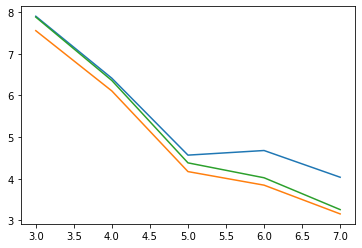

In [26]:
mp.plot(x, parsl_vals[2:])
mp.plot(x, dask_vals[2:])
mp.plot(x, ray_vals[2:])

In [29]:
parsl_vals[0]/parsl_vals[6]

7.79576702716059

In [30]:
dask_vals[0]/dask_vals[6]

8.896780717577478

In [31]:
ray_vals[0]/ray_vals[6]

9.560427988919319